In [74]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report

In [5]:
root_dir = "leedsbutterfly/images"

In [44]:
data = []
labels = []

In [45]:
for file in os.listdir(root_dir):
    label = int(str(file)[:3])
    img = cv2.imread(root_dir + "/" + file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    data.append(img)
    labels.append(label)

In [46]:
data = np.array(data) / 255
labels = np.array(labels)
labels = labels.reshape(832, 1)

In [47]:
onehot = OneHotEncoder()
labels = onehot.fit_transform(labels)

In [48]:
labels.shape

(832, 10)

In [50]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=4242)

In [51]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

83683744/83683744 [==============================] - 8s 0us/step


In [52]:
for layer in base_model.layers:
    layer.trainable = False

In [54]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(10, activation='softmax')(x)

In [55]:
model = Model(inputs=base_model.input, outputs=predictions)

In [56]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [58]:
datagen = ImageDataGenerator(
    rotation_range=15,
    fill_mode="nearest"
)

In [63]:
dataflow = datagen.flow(
    x=X_train,
    y=y_train.toarray(),
    batch_size=32
)

In [64]:
history = model.fit_generator(
    dataflow,
    steps_per_epoch=len(X_train) // 32,
    validation_data=(X_test, y_test.toarray()),
    validation_steps=len(X_test) // 32,
    epochs=10
)

/var/folders/k7/w37qytjn78j3258njhbzvlvr0000gn/T/ipykernel_5728/3363831290.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/10


2023-05-31 23:14:00.984800: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


20/20 [==============================] - 26s 1s/step - loss: 0.5936 - accuracy: 0.8183 - val_loss: 0.0846 - val_accuracy: 0.9880
Epoch 2/10
20/20 [==============================] - 25s 1s/step - loss: 0.0642 - accuracy: 0.9795 - val_loss: 0.1647 - val_accuracy: 0.9521
Epoch 3/10
20/20 [==============================] - 27s 1s/step - loss: 0.0458 - accuracy: 0.9810 - val_loss: 0.0976 - val_accuracy: 0.9760
Epoch 4/10
20/20 [==============================] - 28s 1s/step - loss: 0.0182 - accuracy: 0.9921 - val_loss: 0.0980 - val_accuracy: 0.9760
Epoch 5/10
20/20 [==============================] - 29s 1s/step - loss: 0.0087 - accuracy: 0.9984 - val_loss: 0.0892 - val_accuracy: 0.9760
Epoch 6/10
20/20 [==============================] - 29s 1s/step - loss: 0.0103 - accuracy: 1.0000 - val_loss: 0.0812 - val_accuracy: 0.9760
Epoch 7/10
20/20 [==============================] - 29s 1s/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.0710 - val_accuracy: 0.9880
Epoch 8/10
20/20 [=============

In [66]:
model.save("butterfly.h5")

In [67]:
history_df = pd.DataFrame(history.history)
history_df.head()

,loss,accuracy,val_loss,val_accuracy
0,0.593613,0.818325,0.084634,0.988024
1,0.064201,0.979463,0.164668,0.952096
2,0.045798,0.981043,0.097554,0.976048
3,0.018227,0.992101,0.097973,0.976048
4,0.008720,0.998420,0.089229,0.976048


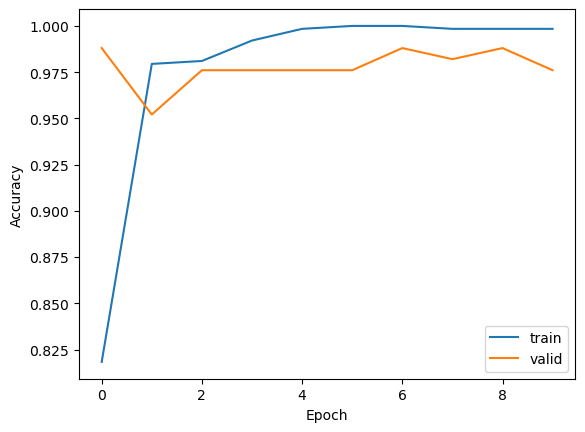

In [68]:
plt.figure()
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["train", "valid"])
plt.show()

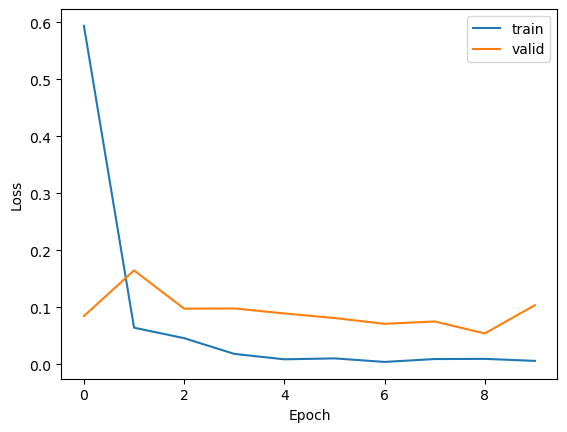

In [69]:
plt.figure()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train", "valid"])
plt.show()

In [70]:
y_pred = model.predict(X_test)

6/6 [==============================] - 5s 826ms/step


In [71]:
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test.toarray(), axis=1)

In [72]:
accuracy_score(y_test, y_pred)

0.9760479041916168

In [75]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00        12
           2       1.00      1.00      1.00        11
           3       0.92      1.00      0.96        11
           4       0.91      0.95      0.93        21
           5       1.00      1.00      1.00        26
           6       1.00      1.00      1.00        18
           7       1.00      1.00      1.00        10
           8       0.94      1.00      0.97        15
           9       1.00      0.88      0.94        25

    accuracy                           0.98       167
   macro avg       0.98      0.98      0.98       167
weighted avg       0.98      0.98      0.98       167

